# Tangles-CNN Training Notebook with Bounding Boxes and Multi-Label Loss

In [1]:
# System imports
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
from PIL import Image
import pandas as pd

# Import modified wildcat
sys.path.append("../tangle-cnn-prod/")
sys.path.append("../tangle-cnn-prod/wildcat_pytorch")
from picsl_wildcat import util, models, losses

# Print basic stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
CUDA status:  True
CUDA memory max alloc:        0 MB


## User parameters
Modify data location and parameters below to your specifications

In [2]:
# Top level data directory. Replace with the directory containing the output of organize_samples.sh 
# The directory must conform to the PyTorch ImageFolder structure
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp02_multiclass"

# Load the manifest file, which has the bounding box sizes 
manifest_file = "/data/pauly2/wildcat/data/thon2019/manifest_2023.csv"

# Create a config object - this gets saved along with the model after training
# Please see Durand CVPR 2018 (WildCat paper) for meaning of kmin, kmax, alpha, num_maps
# The parameter "bounding_box" specifies whether a bounding box is used to limit the
# loss calculation to the box drawn by the user rather than whole patch. Good when users
# draw small boxes around inclusions.
config = {
    "wildcat_upsample": {
        "kmax": 0.02,
        "kmin": 0.0,
        "alpha": 0.7,
        "num_maps": 4,
        "input_size": 224,
        "num_epochs": 30,
        "batch_size": 50,
        "bounding_box": True,
        "bounding_box_min_size": 112
    }
}

In [3]:
# Define useful variables 
bs = config['wildcat_upsample']['batch_size']

## Dataloaders and Transforms

In [4]:
# Patch directory
data_dir = os.path.join(exp_dir, "patches")

# Transforms for training and validation
input_size = config['wildcat_upsample']['input_size']

# Custom transforms to apply
data_transforms = {
    'train': transforms.Compose([
        util.ColorJitterRGB(0.0, 0.0, 0.2, 0.2),
        util.NormalizeRGB([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        util.RandomCrop(input_size),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip()
    ]),
    'val': transforms.Compose([
        util.NormalizeRGB([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.CenterCrop(input_size)
    ]),
}


# Training and validation dataloaders
manifest = pd.read_csv(manifest_file) if config['wildcat_upsample']['bounding_box'] is True else None

# Custom dataset object that generates masks from bounding boxes if needed
image_datasets = {
    x: util.ImageFolderWithBBox(
        os.path.join(data_dir, x), 
        manifest, 
        data_transforms[x],
        config['wildcat_upsample']['bounding_box_min_size']) 
    for x in ['train', 'val']
}

# Custom dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=bs,
        shuffle=True, num_workers=4) 
    for x in ['train', 'val']
}

# Get class information 
class_to_index = image_datasets['train'].class_to_idx
cnames = {v:k for k,v in class_to_index.items() }
n_classes = len(class_to_index)

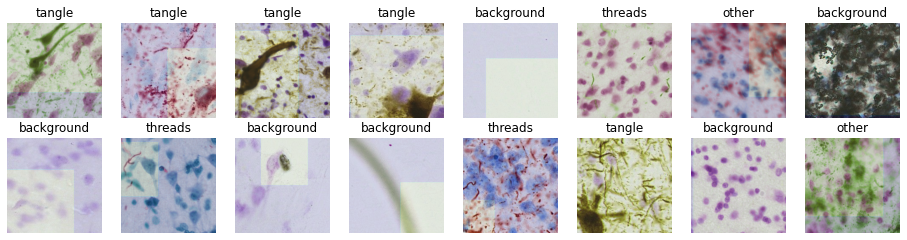

In [5]:
# Read a batch of data from the training data loader
img,label=next(iter(dataloaders['train']))
plt.figure(figsize=(16,6))
util.show_patches_with_masks(img, label, cnames, 8, 0.1, 2)

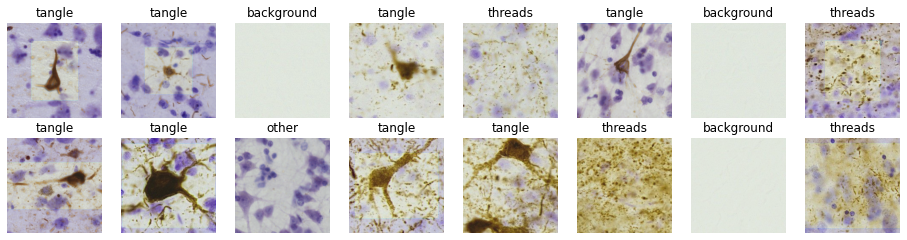

In [6]:
# Also show a batch from the validation model
imgv,labelv=next(iter(dataloaders['val']))
plt.figure(figsize=(16,6))
util.show_patches_with_masks(imgv, labelv, cnames, 8, 0.1, 2)

## Instantiate model

In [49]:
# Define the new funky loss function
class TanglethonLoss(nn.Module):
    
    def __init__(self, weights):
        super(TanglethonLoss, self).__init__()
        self.w = torch.nn.Parameter(weights, requires_grad=False)
        
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        input: [B,K] tensor of activations, for K classes
        target: [B,K] tensor, one-hot-vector
        returns: loss value
        """
        # Map the activations to probabilities
        prob = torch.sigmoid(input)
        
        # Compute the first part of the loss, y_i log(p_i)
        alpha = torch.einsum('bk,bk->b', target, -torch.clamp(torch.log(prob),min=-20))
        
        # Compute the second part of the loss, (1-y_i) log(1-p_i)
        beta = torch.einsum('bk,kl,bl->b', target, self.w, -torch.clamp(torch.log(1-prob), min=-20))
        
        # Result
        res = torch.mean(alpha + beta)
        if torch.isnan(res) or torch.isinf(res):
            print('NONNUMERIC RESULT')
            print(input, target, alpha, beta)
        
        # Return the average loss for this minimatch
        return res
    
    def predictions(self, input: torch.Tensor) -> torch.Tensor:
        """
        Compute predictions for a mini-batch
        """
        # Create an identity matrix for testing 
        idmat = torch.diag(torch.ones_like(torch.diag(self.w)))
        
        # Map the activations to probabilities
        prob = torch.sigmoid(input)
        
        # Compute the first part of the loss, y_i log(p_i)
        alpha = torch.einsum('mk,bk->bm', idmat, -torch.clamp(torch.log(prob),min=-20))
        
        # Compute the second part of the loss, (1-y_i) log(1-p_i)
        beta = torch.einsum('mk,kl,bl->bm', idmat, self.w, -torch.clamp(torch.log(1-prob), min=-20))
        
        # Get the predictions
        _,pred = torch.min(alpha+beta, 1)
        
        return pred

In [50]:
cnames

{0: 'background', 1: 'other', 2: 'tangle', 3: 'threads'}

In [51]:
# Construct the tensor that specifies which classes count against which classes
w=torch.tensor([
    [0,  1/3, 1/3, 1/3],
    [0,  0,   1,   0  ],
    [0,  1,   0,   0  ],
    [0,  1/2, 1/2, 0  ]])
criterion = TanglethonLoss(w)

In [52]:
criterion(torch.tensor([[4.,-3,3,2]]), torch.tensor([[1.,0,0,0]]))

tensor(1.7595)

In [57]:
criterion.predictions(torch.tensor([[4.,-3,3,2],[4.,-3,0.2,2],[4.,-3,0.2,-2]]))

tensor([2, 3, 0])

In [58]:
# Instantiate WildCat model
config['num_classes'] = n_classes
model=models.resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Wrap the model as a bounding box model
model = models.BoundingBoxWildCatModel(model)

# Loss and optimizer
# criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-2)

/home/pauly2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/pauly2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [60]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nmb = len(dataloaders[phase])
            for mb, (inputs, labels) in enumerate(dataloaders[phase]):
                
                # Split out the image and mask portion of the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], n_classes])
                for i in range(n_classes):
                    labels_one_hot[:, i] = (labels == i)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)
                    preds = criterion.predictions(outputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    # Print minibatch stats
                    # print('MB %04d/%04d  loss %f  corr %d  minbox %d' %
                    #       (mb, nmb, loss.item(), torch.sum(preds == labels.data).item(),
                    #       int((mask_interp > 0).sum(2).sum(2).min())))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # print('.', end='')
                print('MB %04d  loss %f  corr %d' % (mb, loss.item(), torch.sum(preds == labels.data).item()))
                sys.stdout.flush()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [61]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=config['wildcat_upsample']['num_epochs'])

Epoch 0/29
----------
MB 0000  loss 1.371846  corr 9
MB 0001  loss 1.274437  corr 19
MB 0002  loss 1.201109  corr 29
MB 0003  loss 1.172366  corr 25
MB 0004  loss 1.144485  corr 35
MB 0005  loss 1.115148  corr 29
MB 0006  loss 1.042333  corr 26
MB 0007  loss 0.936070  corr 37
MB 0008  loss 1.012562  corr 28
MB 0009  loss 0.900502  corr 34
MB 0010  loss 0.845257  corr 32
MB 0011  loss 0.924006  corr 34
MB 0012  loss 0.827526  corr 35
MB 0013  loss 0.840202  corr 36
MB 0014  loss 0.996682  corr 25
MB 0015  loss 0.943088  corr 31
MB 0016  loss 0.860116  corr 30
MB 0017  loss 0.855751  corr 33
MB 0018  loss 0.798341  corr 33
MB 0019  loss 0.728798  corr 36
MB 0020  loss 0.588989  corr 39
MB 0021  loss 0.725096  corr 38
MB 0022  loss 0.684838  corr 36
MB 0023  loss 0.645781  corr 39
MB 0024  loss 0.558250  corr 42
MB 0025  loss 0.625466  corr 37
MB 0026  loss 0.756001  corr 31
MB 0027  loss 0.502637  corr 39
MB 0028  loss 0.589237  corr 36
MB 0029  loss 0.521465  corr 41
MB 0030  loss 0.836

In [19]:
criterion.w

Parameter containing:
tensor([[0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.5000, 0.0000]], device='cuda:0', requires_grad=True)

In [62]:
model_dir

NameError: name 'model_dir' is not defined

## Test model on a batch of data

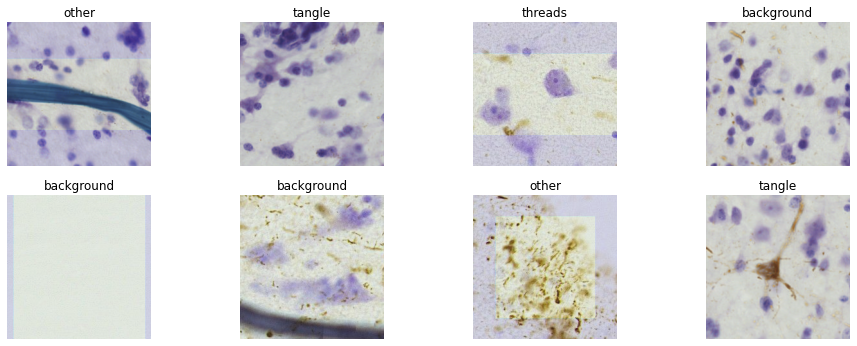

In [122]:
mb, (inputs, labels) = next(enumerate(dataloaders['val']))
plt.figure(figsize=(16,9))
util.show_patches_with_masks(inputs.cpu(), labels.cpu(), cnames, 4, 0.1, 2)

In [128]:
with torch.set_grad_enabled(False):
    y1 = model_ft.wildcat_model.forward_to_classifier(inputs[:,:3,:,:].to(device))
    y2 = model_ft.wildcat_model.spatial_pooling.class_wise.forward(y1)
    preds = criterion.predictions(model_ft(inputs.to(device)))

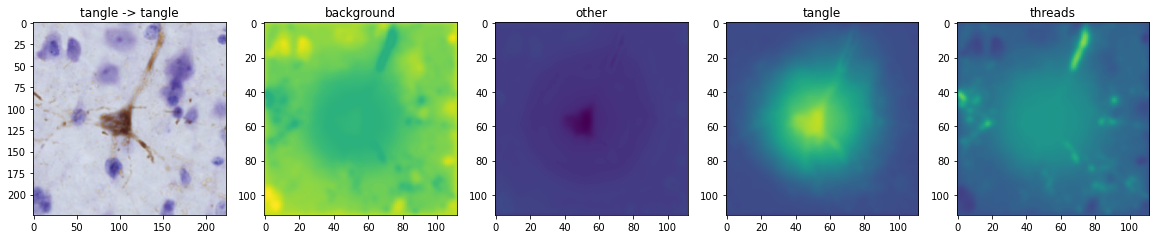

In [129]:
plt.figure(figsize=(20,4))
k = 7
sel = y2[k,:,:,:]
plt.subplot(1,5,1)
plt.imshow(((2.2+inputs[k,0:3,:,:].permute(1,2,0).detach().cpu().numpy()) / 5), vmin=0, vmax=1);
plt.title('%s -> %s' % (cnames[labels[k].data.item()],cnames[preds[k].item()]))
for i in range(4):
    plt.subplot(1,5,i+2)
    plt.imshow(sel[i,:,:].detach().cpu().numpy(), vmin=torch.min(sel), vmax=torch.max(sel).item());
    plt.title('%s' % (cnames[i],))
    # plt.title('%s (%6.4f)' % (cnames[i], res[k,i].item()))

## Export model

In [130]:
# Save the model using a format that can be read using production-time scripts
model_dir = os.path.join(exp_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model_ft.wildcat_model.state_dict(), os.path.join(model_dir, "wildcat_bbox_mlloss.dat"))

# Save the configuration
config['class_to_idx'] = class_to_index
with open(os.path.join(model_dir, 'config.json'), 'w') as jfile:
    json.dump(config, jfile)

Model performance over epochs

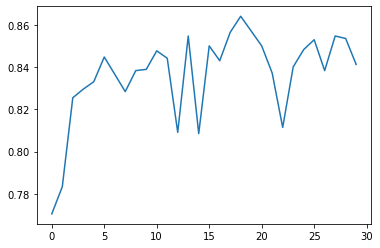

In [135]:
plt.plot([x.item() for x in hist])

In [ ]:
del model_ft
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi